In [1]:
import scipy.io as scio
import matplotlib.pyplot as plt
import time
import math
import tensorflow as tf
from numpy import *
%matplotlib inline

C:\Users\LU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#import data
data = scio.loadmat('dataset.mat')
trainIm = data['train_image']
testIm = data['test_image']
trainLa = data['train_label']
testLa = data['test_label']

In [3]:
#distance function for calculating the distance between two picture
def distance(target,data):
    distance = ((((target - data)**2).sum(axis=1)).sum(axis=0))**0.5
    return distance

In [4]:
KNNdata = None
KNNdis = None
KNNla = None
KNNtrainIm = None
KNNtrainLa = None

#class Kt for KNN tree
class Kt:
    
    def __init__(self,data,left = None,right = None,pix = None,mid = None,node = 0,la = 0):
        self._data = data #picture saved in this node
        self._left = left #left node
        self._right = right #right node
        self._pix = pix #which row is chosen as comparing target
        self._mid = mid #middle value
        self._node = node #this is a node or leaf
        self._la = la #laber of this node 
        global KNNtrainIm
        global KNNtrainLa
        if self._data.shape[0] == 1:
            self._node = 1
            for f in range(0,KNNtrainIm.shape[0]):
                if (self._data[0] == KNNtrainIm[f]).all():
                    self._la = array([KNNtrainLa[f]])
        else:
            self._pix = random.randint(0,data.shape[1]-1)
            self._data = self._data[argsort(self._data.sum(axis=2)[:,self._pix])]
            self._left = Kt(array_split(self._data,2,axis=0)[0])
            self._right = Kt(array_split(self._data,2,axis=0)[1])
            self._mid = array_split(self._data,2,axis=0)[1][0,self._pix].sum(axis=0)
            self._data = None
    
    def search(self,target,k):
        global KNNdis
        global KNNdata
        global KNNla
        if self._node == 0:
            dis = KNNdis
            if target[self._pix].sum(axis=0) < self._mid:
                self._left.search(target,k)
                KNNdata = KNNdata[argsort(KNNdis)][:k]
                KNNdis = KNNdis[argsort(KNNdis)][:k]
                KNNla = KNNla[argsort(KNNdis)][:k]
                if dis is None:
                    self._right.search(target,k)
                elif dis.shape[0]!=KNNdis.shape[0]:
                    self._right.search(target,k)
                elif (dis != KNNdis).all():
                    self._right.search(target,k)
            else:
                self._right.search(target,k)
                KNNdata = KNNdata[argsort(KNNdis)][:k]
                KNNdis = KNNdis[argsort(KNNdis)][:k]
                KNNla = KNNla[argsort(KNNdis)][:k]
                if dis is None:
                    self._left.search(target,k)
                elif dis.shape[0]!=KNNdis.shape[0]:
                    self._left.search(target,k)
                elif (dis != KNNdis).all():
                    self._left.search(target,k)
            return 0
        else:
            dis = distance(self._data[0],target)
            if KNNdata is None:
                KNNdata = self._data
                KNNla = self._la
                KNNdis = array([dis])
            else:
                KNNdata = concatenate((KNNdata,self._data),axis=0)
                KNNla = concatenate((KNNla,self._la),axis=0)
                KNNdis = concatenate((KNNdis,array([dis])),axis=0)
        return 1

In [5]:
#creating KNN tree function
def createKNNtree(trainI,trainL):
    global KNNtrainIm
    global KNNtrainLa
    KNNtrainIm = trainI
    KNNtrainLa = trainL
    tree = Kt(trainI)
    return tree

In [6]:
#testing function
def testKNNtree(testI,testL,k,tree):
    success = 0
    for i in range(0,testI.shape[0]):
        global KNNdis
        global KNNdata
        global KNNla
        KNNdata = None
        KNNdis = None
        KNNla = None
        r = tree.search(testI[i],k)
        realClass = testL[i]
        ones = 0
        oneS = 0
        zeroS = 0
        for h in range(0,k):
            if KNNla[h] == [1]:
                ones = ones+1
                oneS = oneS+KNNdis[h]
            else:
                zeroS = zeroS+KNNdis[h]
        zeros = KNNla.shape[0] - ones
        if (realClass==[0] and zeros>ones) or (realClass==[1] and ones>zeros):
            success = success+1
        elif zeros==ones and ((realClass==[0] and (zeroS/zeros)<=(oneS/ones)) or (realClass==[1] and (zeroS/zeros)>=(oneS/ones))):
            success = success+1
    rate = success/testI.shape[0]
    return rate

In [7]:
start_time = time.time()
KNNtree = createKNNtree(trainIm,trainLa)
print("--- create KNN tree uses %s seconds ---" % (time.time() - start_time))

--- create KNN tree uses 0.5093622207641602 seconds ---


--- test KNN tree k = 1 uses 0.3657069206237793 seconds ---
--- test KNN tree k = 2 uses 0.40326642990112305 seconds ---
--- test KNN tree k = 3 uses 0.42432212829589844 seconds ---
--- test KNN tree k = 4 uses 0.43833184242248535 seconds ---
--- test KNN tree k = 5 uses 0.46131038665771484 seconds ---
--- test KNN tree k = 6 uses 0.45432281494140625 seconds ---
--- test KNN tree k = 7 uses 0.49136853218078613 seconds ---
--- test KNN tree k = 8 uses 0.5183477401733398 seconds ---
--- test KNN tree k = 9 uses 0.5323789119720459 seconds ---
--- test KNN tree k = 10 uses 1.2649061679840088 seconds ---
[0, 1.0, 1.0, 0.86, 0.93, 0.815, 0.835, 0.785, 0.815, 0.805, 0.85]
[0, 0.73, 0.73, 0.71, 0.73, 0.725, 0.74, 0.665, 0.675, 0.695, 0.685]


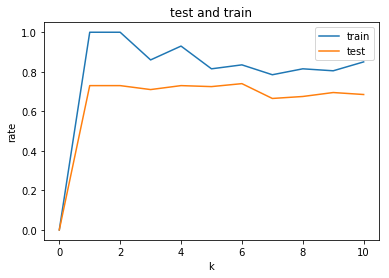

In [8]:
X = arange(0,11,1)
testY = [0]
trainY = [0]

for i in range(1,11):
    start_time = time.time()
    testY.append(testKNNtree(testIm,testLa,i,KNNtree))
    trainY.append(testKNNtree(trainIm,trainLa,i,KNNtree))
    print("--- test KNN tree k = %s uses %s seconds ---" % (i,time.time() - start_time))

print(trainY)
print(testY)
trainY = array(trainY)
testY = array(testY)
plt.plot(X,trainY)
plt.plot(X,testY)
plt.xlabel('k')
plt.ylabel('rate')
plt.title('test and train')
plt.legend(['train', 'test'])

In [9]:
#infomation calculation function for calculating the information in a set of data. return in [information,label]
def infoCal(laset):
    ones = 0
    for i in range(0,laset.shape[0]):
        if laset[i] == [1]:
            ones = ones+1
    if ones == laset.shape[0]:
        return [0,1]
    elif ones == 0:
        return [0,0]
    zeros = (laset.shape[0] - ones)/laset.shape[0]
    ones = ones/laset.shape[0]
    info = -ones*math.log(ones,2) - zeros*math.log(zeros,2)
    if ones < zeros:
        return [info,0]
    return [info,1]

In [10]:
# class for Decision tree
class Dt:
    def __init__(self,data,laber,info,la,left = None,right = None,loc = None,mid = None):
        self._data = data #data in this node
        self._laber = laber #laber of all data
        self._left = left #left node
        self._right = right #right node
        self._loc = loc #location for making decision
        self._mid = mid # middle value
        self._info = info # information of this node
        self._la = la #laber of this node
        global trainIm
        
        if self._info != 0:
            infoArray = [2]
            for h in range(0,self._data.shape[1]):
                Nlaber = self._laber[argsort(self._data.sum(axis=2)[:,h])]
                infoArray.append(infoCal(array_split(Nlaber,2,axis=0)[0])[0]+infoCal(array_split(Nlaber,2,axis=0)[1])[0])
            del infoArray[0]
            self._loc = infoArray.index(min(infoArray))
            self._laber = self._laber[argsort(self._data.sum(axis=2)[:,self._loc])]
            self._data = self._data[argsort(self._data.sum(axis=2)[:,self._loc])]
            
            info = infoCal(array_split(self._laber,2,axis=0)[0])
            self._left = Dt(array_split(self._data,2,axis=0)[0],array_split(self._laber,2,axis=0)[0],info[0],info[1])
            
            info = infoCal(array_split(self._laber,2,axis=0)[1])
            self._right = Dt(array_split(self._data,2,axis=0)[1],array_split(self._laber,2,axis=0)[1],info[0],info[1])
            self._mid = array_split(self._data,2,axis=0)[1][0,self._loc].sum(axis=0)
            
    #get the infomation of this node
    def getInfo(self):
        return self._info
        
    #search for a picture return its predict laber
    def search(self,target,infoR):
        if self._info > infoR:
            if target[self._loc].sum(axis=0) < self._mid:
                return self._left.search(target,infoR)
            return self._right.search(target,infoR)
        return self._la

In [11]:
#function for creating decision tree
def createDTtree(trainI,trainL):
    info = infoCal(trainL)
    tree = Dt(trainI,trainL,info[0],info[1])
    return tree

In [12]:
#testing function for decision tree, return success rate
def testDTtree(testI,testL,tree,infoR):
    success = 0
    for i in range(0,testI.shape[0]):
        la = tree.search(testI[i],infoR)
        realClass = testL[i]
        if realClass == array([la]):
            success = success+1
    rate = success/testI.shape[0]
    return rate

In [13]:
start_time = time.time()
DTtree = createDTtree(trainIm,trainLa)
print("--- decision tree use %s seconds ---" % (time.time() - start_time))

--- decision tree use 0.15613126754760742 seconds ---


--- 0.02101278305053711 seconds ---
--- 0.022016286849975586 seconds ---
--- 0.015010356903076172 seconds ---
--- 0.013010740280151367 seconds ---
--- 0.01803112030029297 seconds ---
--- 0.016993045806884766 seconds ---
[1.0, 1.0, 1.0, 0.995, 0.995, 0.975]
[0.76, 0.76, 0.76, 0.765, 0.765, 0.765]


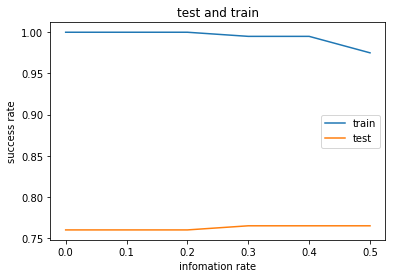

In [14]:
X = arange(0,0.6,0.1)
testY = [0]
trainY = [0]
i = 0

while i < 0.6:
    start_time = time.time()
    testY.append(testDTtree(testIm,testLa,DTtree,i))
    trainY.append(testDTtree(trainIm,trainLa,DTtree,i))
    i = i + 0.1
    print("--- %s seconds ---" % (time.time() - start_time))

del testY[0]
del trainY[0]
print(trainY)
print(testY)
trainY = array(trainY)
testY = array(testY)
plt.plot(X,trainY)
plt.plot(X,testY)
plt.xlabel('infomation rate')
plt.ylabel('success rate')
plt.title('test and train')
plt.legend(['train', 'test'])

In [15]:
#function for adding layer
def addLayer(inputs,inS,outS):
    w = tf.Variable(tf.random_normal([inS, outS]))
    b = tf.Variable(tf.zeros([1,outS]) + 0.1,)
    y = tf.matmul(inputs,w) + b
    outputs = tf.nn.softmax(y)
    return outputs

In [16]:
#function for computing the difference
def computor(x, y):
    global prediction
    y_pre = sess.run(prediction,feed_dict={xs:x})
    correct_pre = tf.equal(tf.argmax(y_pre,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pre, tf.float32))
    result = sess.run(accuracy, feed_dict={xs:x, ys:y})
    return result

--- 14.325831174850464 train seconds ---
--- 24.17406678199768 test seconds ---
[0.485, 0.5, 0.52, 0.525, 0.525, 0.545, 0.565, 0.575, 0.575, 0.585, 0.595, 0.605, 0.615, 0.62, 0.62, 0.625, 0.645, 0.645, 0.66, 0.665, 0.675, 0.685, 0.7, 0.7, 0.705, 0.705, 0.71, 0.715, 0.715, 0.725, 0.73, 0.735, 0.735, 0.735, 0.735, 0.735, 0.735, 0.735, 0.74, 0.74, 0.74, 0.745, 0.745, 0.745, 0.75, 0.75, 0.755, 0.765, 0.765, 0.765, 0.775, 0.775, 0.785, 0.795, 0.81, 0.815, 0.815, 0.815, 0.815, 0.82, 0.835, 0.835, 0.835, 0.855, 0.86, 0.875, 0.885, 0.89, 0.89, 0.91, 0.91, 0.915, 0.915, 0.92, 0.92, 0.92, 0.92, 0.93, 0.945, 0.945, 0.945, 0.945, 0.945, 0.945, 0.95, 0.955, 0.965, 0.965, 0.965, 0.965, 0.965, 0.965, 0.965, 0.965, 0.965, 0.965, 0.965, 0.965, 0.97, 0.97, 0.975, 0.975, 0.975, 0.975, 0.975, 0.98, 0.98, 0.98, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.99, 0.99, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.99

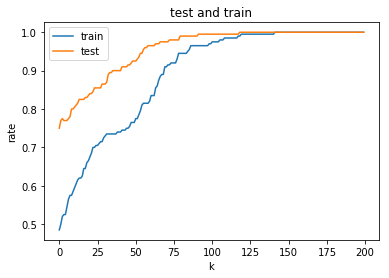

In [17]:
xs = tf.placeholder(tf.float32, [None, 576])
ys = tf.placeholder(tf.float32, [None, 2])

prediction = addLayer(xs,576,2)

ce = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),reduction_indices=[1]))
ts = tf.train.GradientDescentOptimizer(0.1).minimize(ce)

sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

tl1 = [0]
tl2 = [0]
for i in range(0,200):
    tl1.append(1-trainLa[i][0])
    tl2.append(1-testLa[i][0])
del tl1[0]
del tl2[0]
array(tl1)
array(tl2)
tl3 = insert(trainLa,1,values=tl1, axis=1)
tl4 = insert(testLa,1,values=tl2, axis=1)

X = arange(0,200,1)
testY = [0]
trainY = [0]       
start_time = time.time()
for i in range(2000):
    x = trainIm.reshape(200,-1)
    y = tl3
    sess.run(ts, feed_dict={xs:x, ys:y})
    if i % 10 == 0:
        trainY.append(computor(trainIm.reshape(200,-1),tl3))
print("--- %s train seconds ---" % (time.time() - start_time))

start_time = time.time()
for i in range(2000):
    x = testIm.reshape(200,-1)
    y = tl4
    sess.run(ts, feed_dict={xs:x, ys:y})
    if i % 10 == 0:
        testY.append(computor(testIm.reshape(200,-1),tl4))
print("--- %s test seconds ---" % (time.time() - start_time))

del testY[0]
del trainY[0]
print(trainY)
print(testY)
trainY = array(trainY)
testY = array(testY)
plt.plot(X,trainY)
plt.plot(X,testY)
plt.xlabel('k')
plt.ylabel('rate')
plt.title('test and train')
plt.legend(['train', 'test'])
print("--- %s seconds ---" % (time.time() - start_time))